# How to use the `delay_filter` module in `hera_cal`

`hera_cal`'s `delay_filter` module is an interface to the delay_filtering in `uvtools.dspec`. It allows for simple reading of data, performing the delay filter (based on baseline length), and then writing the results to disk.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from hera_cal.delay_filter import Delay_Filter
from hera_cal.data import DATA_PATH
from pyuvdata import UVData
import shutil

## Reading Data

Let's start by loading by creating a `Delay_Filter` object and then loading in some data.

In [2]:
dfil = Delay_Filter()
fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
dfil.load_data(fname)

Alternatively, we could load in data from a pyuvdata object.

In [3]:
dfil = Delay_Filter()
uvd = UVData()
uvd.read_miriad(fname)
dfil.load_data(uvd)

`load_data` also supports lists of either of those kinds of input. `Delay_Filter` objects also suport `load_data_as_dicts`, which allows one to directly input the data, flags, freqs and antpos. If either of these are used, writing to disk (see below) is not available.

This data file contains only a subset of anntenas.

Text(0,0.5,u'Position (m)')

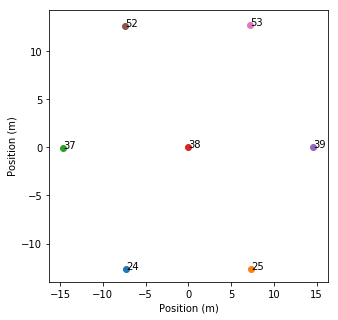

In [4]:
plt.figure(figsize=(5,5))
for ant, pos in dfil.antpos.items():
    plt.scatter(pos[0], pos[1])
    plt.text(pos[0], pos[1], str(ant))
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')

So let's pick the 28 m EW baseline between antennas 37 and 39 and look a the data and flags.

In [5]:
bl = (37, 39, 'xx')

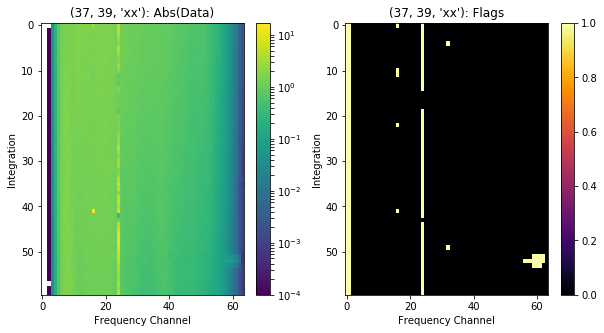

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(dfil.data[bl]), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(Data)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')

plt.subplot(122)
plt.imshow(dfil.flags[bl], aspect='auto', cmap='inferno')
plt.colorbar()
plt.title(str(bl) + ': Flags')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration');

## Performing the Delay Filter

Now let's run the filter. We can run the filter on all baselines simply with:

In [7]:
dfil.run_filter()

We can also filter just a specific baseline or baselines as a list:

In [8]:
dfil.run_filter(to_filter=[bl])

We can also use `run_filter` to access all the keyword arguments of `uvtools.dspec.delay_filter`. The weights default (i.e. `None`) to using the inverse of the flags of the data, but custom linear multiplicative weights can be provided.

In [9]:
dfil.run_filter(to_filter=[bl], weight_dict = None, standoff=15., horizon=1.,
                tol=1e-9, window='none', skip_wgt=0.1, maxiter=100)

The results are stored in the `Delay_Filter` object. `filtered_residuals` is a `DataContainer` that maps baseline/pol keys to the results of the high-pass filter. `CLEAN_models` is also a `DataContainer` that contains the smooth spectrum components found iteratively by `uvtools.dspec.delay_filter` (which itself uses `aipy.deconv.clean`).

Now let's plot some reuslts. Running delay filter removes a lot of the large-spectral scale power in the data. Clearly, there's some power left in, in part due to the band edges and in part due to unflagged RFI. 

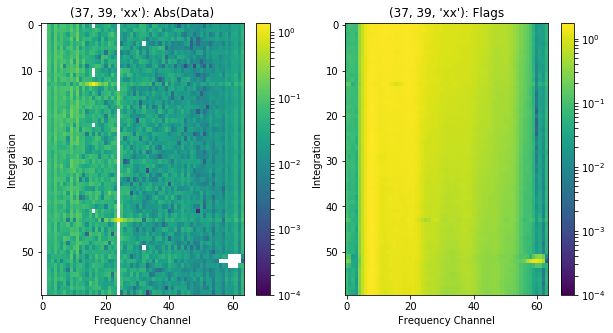

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(121)
res = dfil.filtered_residuals[bl]
res[dfil.flags[bl]] = 0
plt.imshow(np.abs(res), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(Data)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')

plt.subplot(122)
plt.imshow(np.abs(dfil.CLEAN_models[bl]), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Flags')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration');

The `Delay_Filter` also stores the `info` returned from each frequency that the delay CLEANing was performed on. This includes some information about whether or not it ran successfully.

In [11]:
print dfil.info[bl][0]

{'term': 'tol', 'score': 0.0053138752097340912, 'success': True, 'tol': 1e-09, 'iter': 1}


## Writing the Results to Disk

When data is loaded via a single string path or a single `UVData` object, `Delay_Filter` objects enable easy writing to disk of the results. This uses `hera_cal.io.update_vis` to update the input visibility data file or object, only modifying the visibility data.

In [12]:
outfile = os.path.join(DATA_PATH, "test_output/sample_delay_filter_output.uv")
dfil.write_filtered_data(outfile)

`write_filtered_data` supports a number of options that interface with `update_vis` to update other desired parameters. One can choose the filetype of the output, whether to allow the output to overwrite ("clobber") a file in the same location, whether to write out the CLEAN_models (i.e. the low-pass component), and what to append to the history. One can also pass updates to UVData parameters via `**kwargs`.

In [13]:
dfil.write_filtered_data(outfile, filetype_out='miriad', clobber = True, write_CLEAN_models=True,
                         add_to_history = 'Written with running_delay_filter.ipynb.')

File exists: clobbering


In [14]:
shutil.rmtree(outfile)